# REINFORCE-improvements
* Noise reduction
* Reward Normalization

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('MountainCar-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)


class Policy(nn.Module):
#     def __init__(self, s_size=4, h_size=16, a_size=2):
    def __init__(self, h_size=16):
        super(Policy, self).__init__()
        s_size = env.observation_space.shape[0]
#         a_size = env.action_space.shape[0]  # for continuous action spaces
        a_size = env.action_space.n    # for discrete action spaces
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # return a tensor containing the probabilities of each action
        return F.softmax(x, dim=1)
#         return x.cpu().data

    
    def act(self, state):
        # transform the state to a torch tensor and send it to device (GPU or CPU) 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # compute the action probabilities -> do the rest of the calculation on CPU
        probs = self.forward(state).cpu()
        # Create a categorical distribution parameterized by probs
        m = Categorical(probs)
        # sample according to the underlying probability
        action = m.sample()
        # return the action item and the log of the underlying probability!
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=3000, max_t=1000, gamma=1.0, print_every=100):
    # save the last 100 scores within a double-ended-queue 
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # run n_trajectories trajectories
        n_trajetories = 5
        trajectory_reward = []
        trajectory_log_probs = []
        trajectory_loss = []
        reward_mu = 0
        reward_sigma = 0
        
        for i_trajectory in range(n_trajetories):
            saved_log_probs = []
            rewards = []
            # reset the state
            state = env.reset()
            for t in range(max_t):
                # get the next action (item) and the log of its underlying probability
                action, log_prob = policy.act(state)
                # store the log of the underlying probability!
                saved_log_probs.append(log_prob)
                # do the next step in the environment according to the action
                state, reward, done, _ = env.step(action)
                # store the reward
                rewards.append(reward)
                if done:
                    break
            # sum up the rewards of the trajectory and store it in the double-ended-queue
            scores_deque.append(sum(rewards))
             # sum up the rewards of the trajectory and store it
            scores.append(sum(rewards))

            # calculate the discount factor
            discounts = [gamma**i for i in range(len(rewards)+1)]
            # cumpute the total reward of the trajectory (discount * reword) = R(tau^i_episode)
            R = sum([a*b for a,b in zip(discounts, rewards)])

            policy_loss = []
            # multiply each saved log probability of the trajectory with the total reward R(tau^i_episode) 
            for log_prob in saved_log_probs:
                policy_loss.append(-log_prob * R)
            # concatenate the computed values and sum them up
            # => sum of the log probabilities * R(tau^i_episode)
            policy_loss = torch.cat(policy_loss).sum()
            
            trajectory_reward.append(R)
            trajectory_log_probs.append(saved_log_probs)
        
        # compute the normalized reward
        reward_mu = sum(trajectory_reward) / n_trajetories
        
        tt = []
        for r in trajectory_reward:
            tt.append((r - reward_mu)**2)
            
        reward_sigma = sum(tt) / n_trajetories
#         print(reward_sigma)
        
        R_normalized = []
        for r in trajectory_reward:
            if reward_sigma > 0:
                R_normalized.append((r-reward_mu) / reward_sigma)
            else:
                R_normalized.append(reward_mu)
        
        # 
        for i, log_probs in enumerate(trajectory_log_probs):
            policy_loss = []
            for log_prob in log_probs:
                policy_loss.append(-log_prob * R_normalized[i])
            trajectory_loss.append(torch.cat(policy_loss).sum())
        
        trajectory_policy_loss = sum(trajectory_loss) / n_trajetories        

        # reset the gradints to zero (because they are accumulated)
        optimizer.zero_grad()
        # compute the gradiants = ĝ => U(theta)
        trajectory_policy_loss.backward()
        # do the weight updates
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=150.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Environment solved in 98 episodes!	Average Score: 150.19


### 4. Plot the Scores

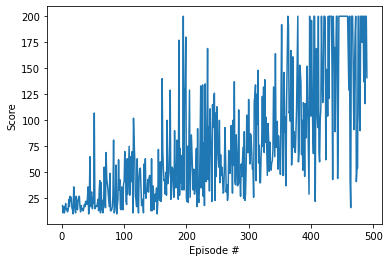

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [6]:
import time

# env = gym.make('CartPole-v0')
# env = gym.make('MountainCar-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    time.sleep(0.02)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()